In [1]:

# !pip install ipykernel

import os 

os.chdir('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main')
# from dataloaders.datasets.nyud_geonet import NYUD_GeoNet
from dataloaders.datasets.nyud_geonet import *
import matplotlib.pyplot as plt
import numpy as np 
import cv2
import torchvision.transforms as transforms
from utils.utils import  * 
import math
import torch.nn.functional as F
from plot.plot_main_pic import dilation
import copy


#* initial
# plt.rcParams['figure.figsize'] = (6.0, 4.0) # 设置figure_size尺寸
# plt.rcParams['image.interpolation'] = 'nearest' # 设置 interpolation style
# plt.rcParams['image.cmap'] = 'gray' # 设置 颜色 style
# plt.rcParams['savefig.dpi'] = 200 #图片像素
# plt.rcParams['figure.dpi'] = 200 #分辨率
# 默认的像素：[6.0,4.0]，分辨率为100，图片尺寸为 600&400



Bad key text.latex.preview in file /home/DISCOVER_summer2022/xusc/.conda/envs/uav/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/DISCOVER_summer2022/xusc/.conda/envs/uav/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/DISCOVER_summer2022/xusc/.conda/envs/uav/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('s

Number of dataset images: 654
0-th image is processing
1-th image is processing
2-th image is processing
3-th image is processing
4-th image is processing
5-th image is processing


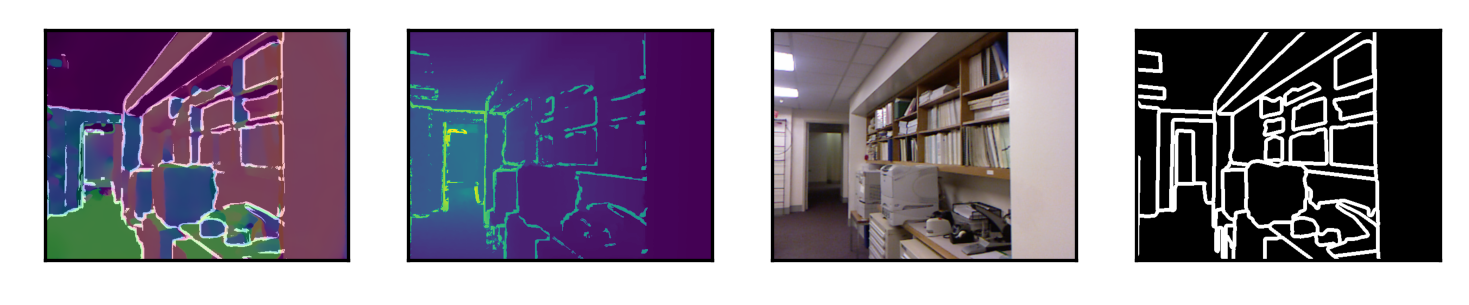

In [5]:


db = NYUD_GeoNet(split='val',root='/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/data/nyud2')

for i, (sample,name) in enumerate(db):
    print(f"{i}-th image is processing")
    # print(sample["image"].shape,sample["depth"].shape,sample["normals"].shape,sample["edge"].shape)
    # print('image',sample["image"].max(),sample["image"].min())
    # print('depth',sample["depth"].max(),sample["depth"].min())
    # print('normals',sample["normals"].max(),sample["normals"].min())
    # print('edge',sample["edge"].max(),sample["edge"].min())
    # print(sample.keys())
    #!===================
    # normal_threshold = 0.001
    # depth_threshold = 0.008
    
    # normal_threshold = 0.0005
    # depth_threshold = 0.001

    # normal_threshold = 0.0008
    # depth_threshold = 0.01
    #!===================

    normal_threshold = 0.03
    depth_threshold = 0.01
    # __depth=normalize(sample['depth'])
    # depth_edge_map = np.concatenate([__depth[...,None],__depth[...,None],__depth[...,None]],axis=-1)
    # depth_edge_map = detect_edge(depth_edge_map)
    # normal_edge_map = detect_edge(normal_reverse_process(sample['normals']))
    # show_imgs([depth_edge_map,normal_edge_map],[1,1])

    # H,W = sample['edge'].shape
    # for i in range(H):
    #     for j in range(W):
            
    #         edge_neighbors = get_neighbors(i,j,sample['edge'])
            
    #         if edge_neighbors.sum()==0:
    #             depth_edge_map[i,j]=0
    #             normal_edge_map[i,j]=0

    #* plan1
    
    # show_imgs([new_edge,depth_edge_map,normal_edge_map],[1,1,1])
    

    depth_edge,normal_edge = get_normal_depth_edge(
                        sample["depth"],sample["normals"],
                        normals_threshold=normal_threshold,depth_threshold=depth_threshold)
    
    # show_imgs([sample["normals"],normal_edge*255],[0,1])
    # show_imgs([sample["depth"],depth_edge*255],[0,1])
    # show_imgs([sample["edge"]],[1])

    #!+===========
    
    new_depth_edge =copy.deepcopy(depth_edge)
    new_normal_edge =copy.deepcopy(normal_edge)
    dilation_factor= 3
    new_edge=dilation(sample['edge'],dilation_factor)
    new_edge = F.interpolate(torch.from_numpy(new_edge)[None,None],size=depth_edge.shape)

    new_edge=new_edge.squeeze().numpy()
    new_depth_edge[new_edge!=255] =0
    new_normal_edge[new_edge!=255] =0
    #!+===========


    
    # a = merge_images( (normal_reverse_process(sample['normals'])*255).astype(np.uint8),0.5,
    #                     np.array(normal_edge).astype(np.uint8)*255,0.5)
    # b = merge_images((normalize(sample['depth'])*255).astype(np.uint8)
    #                     ,0.5,np.array(depth_edge).astype(np.uint8)*255,0.5)
    # show_imgs([a,b,sample['image'],new_edge],[0,1,0,1],img_name="%06d_filter_by_edge.png"%(i))

    c = merge_images( (normal_reverse_process(sample['normals'])*255).astype(np.uint8),0.5,
                        np.array(new_normal_edge).astype(np.uint8)*255,0.5)
    d = merge_images((normalize(sample['depth'])*255).astype(np.uint8)
                        ,0.5,np.array(new_depth_edge).astype(np.uint8)*255,0.5)

    show_imgs([c,d,sample['image'],new_edge],[0,0,0,1],img_name="%06d_filter_by_edge%d.png"%(i,dilation_factor))

    if i==5:
        break


# show_imgs([sample["image"],sample["depth"],sample["normals"],sample["edge"]],gray_mode=[0,1,0,1],)
# show_imgs([merge_images(sample["image"],0.5,sample["edge"]*255,0.5)],[0],['merge image and edge'],img_name='img_edge.png')
# show_imgs([merge_images(np.array(normal_reverse_process(sample["normals"])*255,np.uint8),0.5,sample["edge"]*255,0.5)],[0],['merge normals and edge'],img_name='normals_edge.png')
# show_imgs([merge_images(np.array(normalize(sample["depth"])*255).astype(np.uint8),0.5,sample["edge"]*255,0.5)],[0],['merge depth and edge'],img_name='depth_edge.png')


